In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
import torchvision.models as models

In [2]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# torch.save(model, "resnetinceptionv1_epoch_32.pth")

In [3]:
model = torch.load("resnetinceptionv1_epoch_32.pth", map_location=device)
model.to(device)
model.eval()

C:\Users\Shreya Jadhav\AppData\Local\Temp\ipykernel_10524\1505874650.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("resnetinceptionv1_epoch_32.pth",

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Load and preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image, image_tensor

# Function to generate a heatmap using Grad-CAM for ResNet
def generate_heatmap(model, image_tensor):
    image_tensor.requires_grad_()
    
    # Get last convolutional layer (for ResNet, it's layer4)
    last_conv_layer = model.layer4[-1]  # Last block of layer4
    
    # Store gradients and activations
    gradients = None
    activations = None
    
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]  # Gradient of output w.r.t input
    
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output  # Activation maps of the last conv layer
    
    # Register hooks
    forward_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_handle = last_conv_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    output = model(image_tensor)
    prediction = torch.argmax(output, dim=1)

    # Zero gradients & Backprop
    model.zero_grad()
    class_score = output[0, prediction]  
    class_score.backward()

    # Convert gradients & activations to numpy
    gradients = gradients.cpu().detach().numpy()
    activations = activations.cpu().detach().numpy()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute importance of each activation channel
    weights = np.mean(gradients, axis=(2, 3))  # Global Average Pooling
    heatmap = np.sum(activations * weights[:, :, np.newaxis, np.newaxis], axis=1)
    
    # Apply ReLU and Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap[0]  # Return the first image heatmap

# Apply the heatmap to the image
def overlay_heatmap(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Convert to red-green scale (Red for fake, Green for real)
    red_part = (heatmap_colored[:, :, 2] > heatmap_colored[:, :, 1]) * 255
    green_part = (heatmap_colored[:, :, 1] > heatmap_colored[:, :, 2]) * 255
    
    mask = np.zeros_like(image)
    mask[:, :, 1] = green_part  # Green channel for real parts
    mask[:, :, 2] = red_part    # Red channel for fake parts

    final_image = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return final_image

def apply_custom_colormap(heatmap):
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = np.uint8(heatmap)

    # Convert grayscale heatmap to BGR
    heatmap_bgr = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2BGR)

    # Define color masks: Fake (Red), Real (Green)
    red_mask = np.zeros_like(heatmap_bgr)
    red_mask[:, :, 2] = heatmap  # Assign to Red channel

    green_mask = np.zeros_like(heatmap_bgr)
    green_mask[:, :, 1] = 255 - heatmap  # Assign to Green channel

    # Combine red and green masks
    custom_heatmap = cv2.addWeighted(red_mask, 0.7, green_mask, 0.3, 0)
    return custom_heatmap

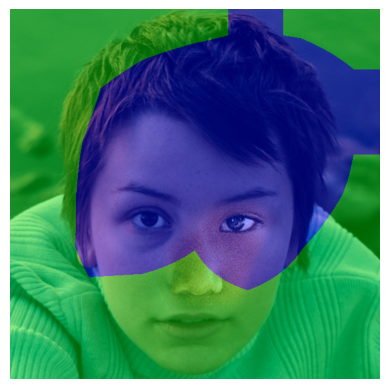

In [7]:
# Load Image and Process
image_path = r"D:\Degree\TY6\Project_II\deepfake_detection\data\fake\easy_35_0110.jpg"
original_image, image_tensor = preprocess_image(image_path)
heatmap = generate_heatmap(model, image_tensor)
final_output = overlay_heatmap(original_image, heatmap)

# Display Results
plt.imshow(final_output)
plt.axis("off")
plt.show()